In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
import seaborn as sns

In [6]:
loans = pd.read_csv('./input/SBAnational.csv')
loans.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [7]:
loans.shape

(899164, 27)

# **Data Understanding**

In [8]:
loans.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

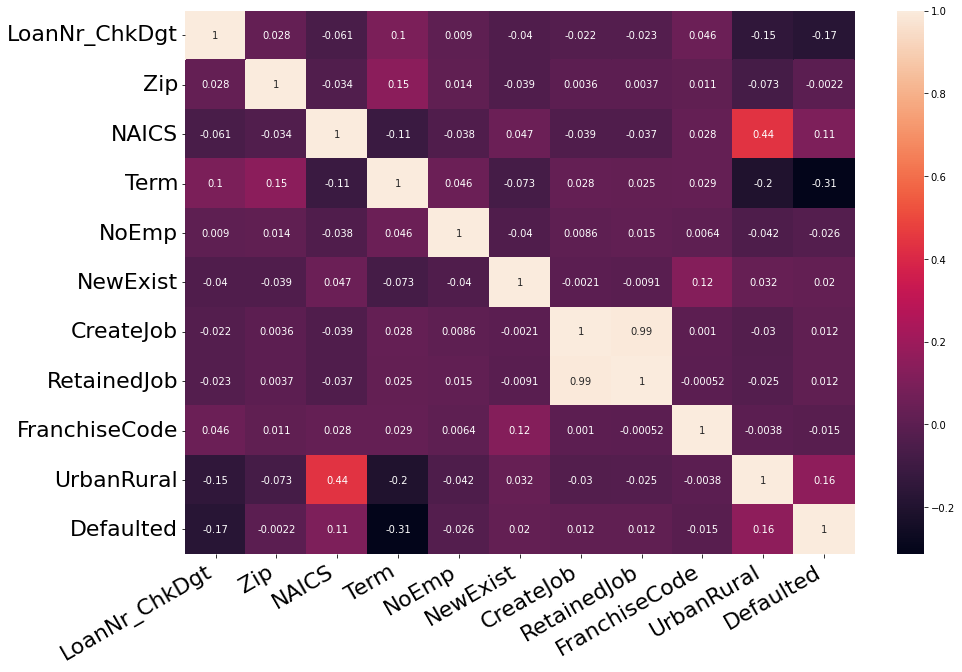

In [9]:
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
# we nneded to make MIS_Status binary in order to display it in the correlation matrix
# it is a part of the data preparation
loans['Defaulted'] = [1 if app == 'CHGOFF' else 0 for app in loans.MIS_Status.values]
corr_matrix = loans.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('correlation.png')
plt.show()

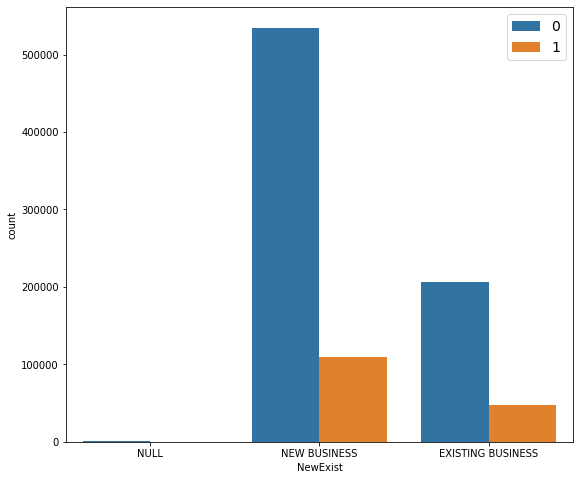

In [10]:
fig2 = plt.figure(figsize=(20,8))
ax1 = fig2.add_subplot(1, 2, 1)
plt.rcParams.update({'font.size': 14})
sns.countplot(x="NewExist", hue="Defaulted", data=loans)
plt.legend()

labels = ("NULL", "NEW BUSINESS", "EXISTING BUSINESS")
positions = (0, 1, 2)
plt.xticks(positions, labels)
plt.savefig('new_exist.png')
plt.show()

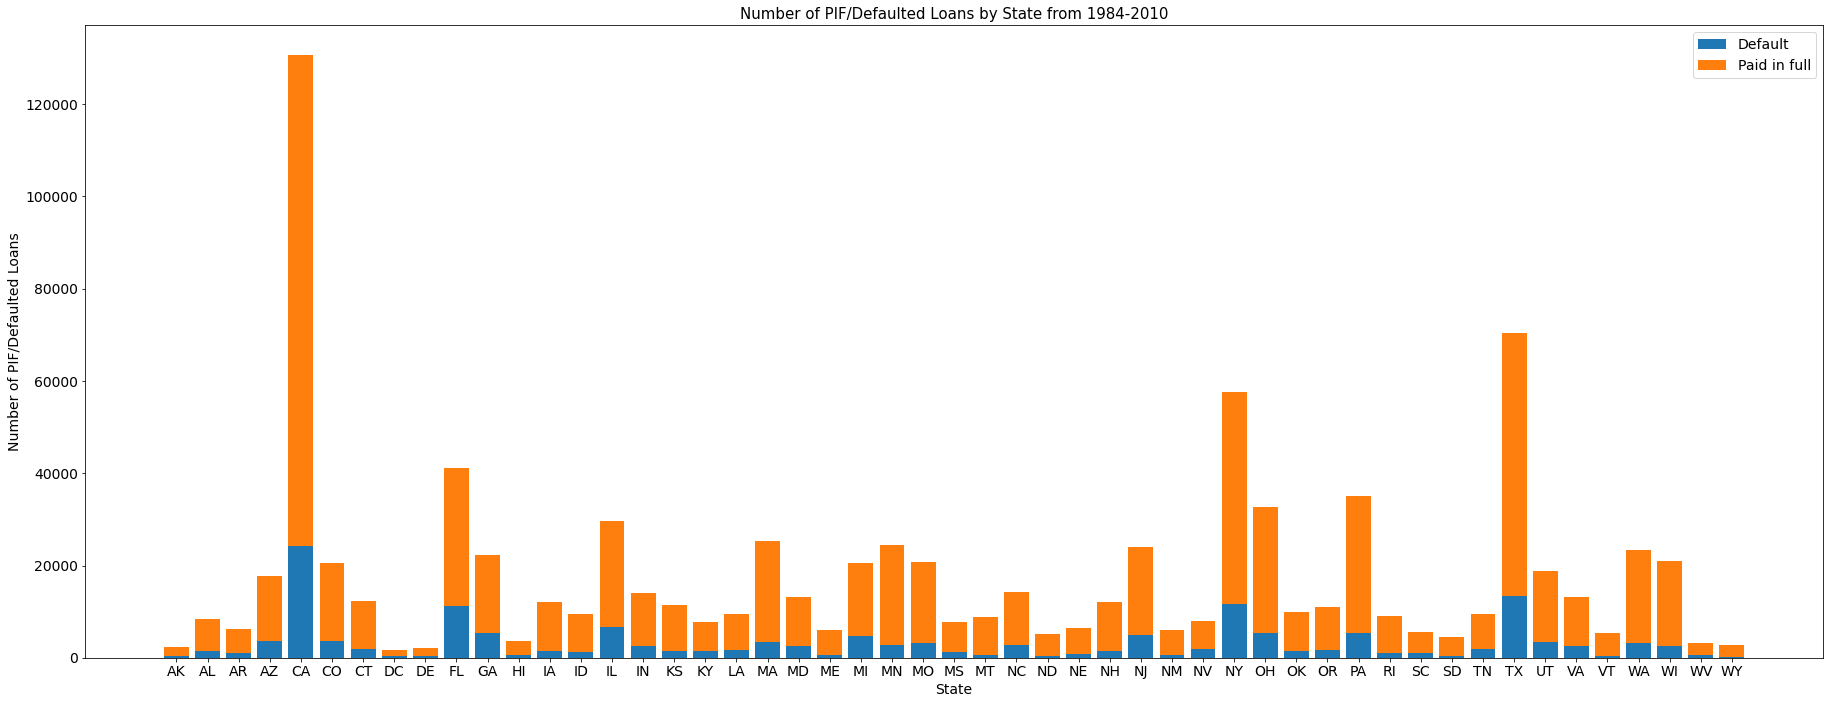

In [11]:
fig3 = plt.figure(figsize=(50, 10))

ax1 = fig3.add_subplot(1, 2, 1)

df = loans.copy()

df['Default'] = np.where(df['MIS_Status'] == 'P I F', 0, 1)
df['Default'].value_counts()

data = df.groupby(['State', 'Default'])['State'].count().unstack('Default')
data.fillna(0)

ax1.bar(data.index, data[1], label='Default')
ax1.bar(data.index, data[0], bottom=data[1], label='Paid in full')

ax1.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax1.set_xlabel('State')
ax1.set_ylabel('Number of PIF/Defaulted Loans')
ax1.legend()

plt.tight_layout()

plt.savefig('states.png')
plt.show()

In [12]:
loans.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'Defaulted'],
      dtype='object')

# **Data Preparation**

In [13]:
# we want to make a binary value stating if the loan was defaulted or not
loans = loans.drop(columns=['MIS_Status'])

# we only take the loans created before 2007
loans['ApprovalFY'] = loans['ApprovalFY'].replace({'A':'','B':''}, regex = True).astype(int)
loans.drop(loans[loans['ApprovalFY']>2007].index, axis = 0, inplace = True)

loans = loans.drop(columns=['ApprovalFY','ApprovalDate','DisbursementDate','ChgOffDate','LoanNr_ChkDgt','Name','Zip', 'City', 'Bank'])

In [14]:
loans.head()

,State,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,Defaulted
0,IN,OH,451120,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",$0.00,$0.00,"$60,000.00","$48,000.00",0
1,IN,IN,722410,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",$0.00,$0.00,"$40,000.00","$32,000.00",0
2,IN,IN,621210,180,7,1.0,0,0,1,0,N,N,"$287,000.00",$0.00,$0.00,"$287,000.00","$215,250.00",0
3,OK,OK,0,60,2,1.0,0,0,1,0,N,Y,"$35,000.00",$0.00,$0.00,"$35,000.00","$28,000.00",0
4,FL,FL,0,240,14,1.0,7,7,1,0,N,N,"$229,000.00",$0.00,$0.00,"$229,000.00","$229,000.00",0


In [15]:
loans.shape

(802319, 18)

In [16]:
def amount_to_float(number):
    num = number.replace("$", "")
    num = num.replace(",","")
    num = num.replace(" ","")
    return float(num)

#instead of dealing with money as a string we will deal with it as a number
loans['BalanceGross'] = loans['BalanceGross'].apply(lambda x: amount_to_float(x))
loans['DisbursementGross'] = loans['DisbursementGross'].apply(lambda x: amount_to_float(x))
loans['ChgOffPrinGr'] = loans['ChgOffPrinGr'].apply(lambda x: amount_to_float(x))
loans['GrAppv'] = loans['GrAppv'].apply(lambda x: amount_to_float(x))
loans['SBA_Appv'] = loans['SBA_Appv'].apply(lambda x: amount_to_float(x))

In [17]:
# we replace it to be a binary where 1 to be a new business and 0 an old business
loans['NewExist'] = loans['NewExist'].replace(1,0)
loans['NewExist'] = loans['NewExist'].replace(2,1)

In [18]:
# we replace the LowDoc values to be binary instead of Y and N
loans['LowDoc'] = loans['LowDoc'].replace({'Y':'1', 'N':'0'}, regex=True)
valid = ['1', '0']
loans = loans.loc[loans['LowDoc'].isin(valid)]
loans['LowDoc'] = loans['LowDoc'].astype(int)

<ipython-input-18-cdff927ea5ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['LowDoc'] = loans['LowDoc'].astype(int)


In [19]:
# we replace the RevLineCr values to be binary instead of Y and N
loans['RevLineCr'] = loans['RevLineCr'].replace({'Y':'1', 'N':'0'}, regex=True)
loans = loans.loc[loans['RevLineCr'].isin(valid)]
loans['RevLineCr'] = loans['RevLineCr'].astype(int)

<ipython-input-19-4f9f7ad3819d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['RevLineCr'] = loans['RevLineCr'].astype(int)


In [20]:
# we make FranchiseCode a binary column named Franchise where 1 is true and 0 is false
loans['FranchiseCode'] = loans['FranchiseCode'].replace(1,0)
loans['FranchiseCode'] = np.where((loans.FranchiseCode != 0),1,loans.FranchiseCode)
loans.rename(columns={"FranchiseCode":"Franchise"},inplace=True)

<ipython-input-20-932e5fefa3ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['FranchiseCode'] = loans['FranchiseCode'].replace(1,0)
<ipython-input-20-932e5fefa3ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['FranchiseCode'] = np.where((loans.FranchiseCode != 0),1,loans.FranchiseCode)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [21]:
loans.shape

(783512, 18)

In [22]:
# we get dummies for the catagorical columns BankState and State
loans = pd.get_dummies(loans,columns=['BankState','State'],prefix=['BankState','State'])

In [23]:
# only take the first 2 digits from the NAICS values
def first_n_digits(number, n):
    return int(str(number)[:n])
loans['NAICS'] = loans['NAICS'].apply(lambda x: first_n_digits(x,2))

In [24]:
loans.head()

,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,Franchise,UrbanRural,RevLineCr,LowDoc,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,45,84,4,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,72,60,2,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,62,180,7,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,60,2,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,240,14,0.0,7,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
loans['NAICS'].unique()

array([45, 72, 62,  0, 33, 81, 23, 44, 42, 61, 53, 54, 31, 51, 71, 52, 21,
       32, 56, 48, 11, 92, 22, 49, 55])

In [26]:
loans.columns

Index(['NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'Franchise', 'UrbanRural', 'RevLineCr', 'LowDoc',
       ...
       'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT',
       'State_WA', 'State_WI', 'State_WV', 'State_WY'],
      dtype='object', length=122)

In [27]:
loans.dtypes

NAICS          int64
Term           int64
NoEmp          int64
NewExist     float64
CreateJob      int64
              ...   
State_VT       uint8
State_WA       uint8
State_WI       uint8
State_WV       uint8
State_WY       uint8
Length: 122, dtype: object

# **Modeling**

In [28]:
# we seperate the values we want to classify
y = loans['Defaulted']
X = loans.drop(columns=['Defaulted'])
y_backup = y
X = X.to_numpy()
y = pd.get_dummies(y)
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [29]:
# the ration between the 0s and 1s is about 1:5
y_backup.value_counts()

0    656260
1    127252
Name: Defaulted, dtype: int64

In [30]:
# we create the encoder layers of the auto-encoder neuron network
n_inputs = X.shape[1]
e = Sequential()
e.add(Dense(100, activation = 'tanh', input_shape = [n_inputs]))
e.add(Dense(50, activation = 'tanh'))
e.add(Dense(16, activation = 'tanh'))
e.add(Dense(2, activation = 'tanh'))

In [31]:
# we create the decoder layers of the auto-encoder neuron network
d = Sequential()
d.add(Dense(16, activation = 'tanh', input_shape = [2]))
d.add(Dense(50, activation = 'tanh'))
d.add(Dense(100, activation = 'tanh'))
d.add(Dense(n_inputs, activation = 'tanh'))

In [32]:
# define auto-encoder model
autoencoder = Sequential([e, d])

In [33]:
# compile auto-encoder model
autoencoder.compile(optimizer='adam', loss='mse')

n_epochs = 10
batch_size = 256

X_train = np.asarray(X_train).astype('float32')

# we train the auto-encoder with the X_train
fit_time = autoencoder.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size,verbose=0)

In [34]:
# we predict the output values of the encoder for the train and test via compression
enc_X_train = e.predict(X_train)
enc_X_test = e.predict(X_test)

6122/6122 [==============================] - 8s 1ms/step


In [35]:
# we use a Decision Tree Classifier to evaluate our model
clf = DecisionTreeClassifier()

y_train_labels = np.argmax(y_train, axis = 1)
y_test_labels = np.argmax(y_test, axis = 1)

In [36]:
clf.fit(enc_X_train, y_train_labels)

DecisionTreeClassifier()

# **Evaluation**

In [37]:
y_pred = clf.predict(enc_X_test)

print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    164065
           1       0.96      0.88      0.92     31813

    accuracy                           0.97    195878
   macro avg       0.97      0.93      0.95    195878
weighted avg       0.97      0.97      0.97    195878



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


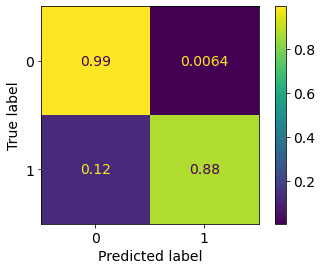

In [38]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf,enc_X_test,y_test_labels, normalize = 'true')

In [39]:
cm = confusion_matrix(y_test_labels, y_pred)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# we use the WACC matric from the article
# http://store.ectap.ro/articole/1421.pdf

WACC = 0.25*(TP/(TP+FN))+0.75*(TN/(TN+FP)) 
print('The WACC rank of our model is: '+str(WACC))

The WACC rank of our model is: 0.9641048605081529
